This notebook builds/loads RNNs to simulate the double serial retrocuing (DSR) working memory task, and then visualize the internal dynamics of stimulus representation using PCA.

Credit: Quan Wan and Adel Ardalan

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf. __version__)

2.15.0


In [ ]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.10

In [ ]:
import sys, os, re, datetime

import numpy as np
import scipy.io
import pandas as pd
from sklearn.decomposition import PCA

import tensorflow as tf
import keras
import keras.utils as ku
from keras.layers import Input, Activation, Dense, Dropout, TimeDistributed, RNN

%cd /content/gdrive/My Drive/

from firing_rate_rnn import FiringRateRNNCell, get_orientation_tuned_firing_rate_response

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
from mpl_toolkits import mplot3d
from matplotlib import colorbar as pltcb
from matplotlib import colors as pltcs
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

/content/gdrive/My Drive


In [ ]:
from IPython.core.display import display, HTML, Video
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


for print_type in ['HEADER', 'OKBLUE', 'OKCYAN', 'OKGREEN', 'WARNING', 'FAIL', 'BOLD', 'UNDERLINE']:
    exec(f"""def bcp_{print_type}(x):
    #print(bcolors.{print_type}+str(x)+bcolors.ENDC)
    sys.stdout.write(bcolors.{print_type}+str(x)+bcolors.ENDC); sys.stdout.flush()
""")


# Build Input Data

This example takes `num_orituned_input_units` orientation-tuned inputs and `num_retrocue_input_units` retrocues as input and returns two output units, cos and sin of the orientation of the cued stimulus.

In [ ]:
num_trials               = 5000
timesteps                = 350
num_orituned_input_units = 32
num_retrocue_input_units = 1
num_input_units          = num_orituned_input_units + num_retrocue_input_units
resp1_unit1 = np.zeros(num_trials)
resp1_unit2 = np.zeros(num_trials)
resp2_unit1 = np.zeros(num_trials)
resp2_unit2 = np.zeros(num_trials)


stims1     = np.random.uniform(0, np.pi, num_trials)
stims2     = np.random.uniform(0, np.pi, num_trials)
cues1      = np.random.choice(np.array([1,-1]),num_trials)
cues2      = np.random.choice(np.array([1,-1]),num_trials)

for tr in range(num_trials):
    if cues1[tr] == 1:
        resp1_unit1[tr] = np.cos(2*stims1[tr])
        resp1_unit2[tr] = np.sin(2*stims1[tr])
    else:
        resp1_unit1[tr] = np.cos(2*stims2[tr])
        resp1_unit2[tr] = np.sin(2*stims2[tr])

    if cues2[tr] == 1:
        resp2_unit1[tr] = np.cos(2*stims1[tr])
        resp2_unit2[tr] = np.sin(2*stims1[tr])
    else:
        resp2_unit1[tr] = np.cos(2*stims2[tr])
        resp2_unit2[tr] = np.sin(2*stims2[tr])

inputs  = np.zeros((num_trials, timesteps, num_input_units))
outputs = np.zeros((num_trials, timesteps, 2))

for tt in range(0, 50):
    resps1 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims1
             ]
    inputs[:, tt, :num_orituned_input_units] = resps1

for tt in range(100, 150):
    resps2 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims2
             ]
    inputs[:, tt, :num_orituned_input_units] = resps2

for tt in range(200, 250): #cue 1
    inputs[:,tt,-1] = cues1
    outputs[:,tt,0] = resp1_unit1
    outputs[:,tt,1] = resp1_unit2

for tt in range(300, 350): #cue 2
    inputs[:,tt,-1] = cues2
    outputs[:,tt,0] = resp2_unit1
    outputs[:,tt,1] = resp2_unit2


In [ ]:
inputs = tf.convert_to_tensor(inputs)
outputs = tf.convert_to_tensor(outputs)

print('inputs shape: ', inputs.shape)
print('outputs shape', outputs.shape)

inputs shape:  (5000, 350, 33)
outputs shape (5000, 350, 2)


# Split Data Into Train/Test

In [ ]:
splitidx = int(0.8*inputs.shape[0])
xtraintensor = inputs[:splitidx]
xtesttensor = inputs[splitidx:]
ytraintensor = outputs[:splitidx]
ytesttensor = outputs[splitidx:]

In [ ]:
xtesttensor.shape

TensorShape([1000, 350, 33])

# Create The Firing Rate Recurrent Neural  Network

In [ ]:
recurrent_unit_activation =  'relu'

input_layer = Input(shape=xtraintensor.shape[1:], name="input_layer")
recurrent_layer = RNN(FiringRateRNNCell(
                        units=100,
                        activation=recurrent_unit_activation,
                        use_bias=True,
                        recurrent_units_noise_std=0.01,
                      ),
                      return_sequences=True
                  )(input_layer)
act_layer = Activation(recurrent_unit_activation)(recurrent_layer)
output_layer = TimeDistributed(Dense(2, activation='tanh'))(act_layer)

frmodel = keras.Model(inputs=[input_layer,],
                    outputs=output_layer,
                    name='firing_rate_model'
                   )
frmodel.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
frmodel.summary()

Model: "firing_rate_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 350, 33)]         0         
                                                                 
 rnn (RNN)                   (None, 350, 100)          13400     
                                                                 
 activation (Activation)     (None, 350, 100)          0         
                                                                 
 time_distributed (TimeDistr  (None, 350, 2)           202       
 ibuted)                                                         
                                                                 
Total params: 13,602
Trainable params: 13,602
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [ ]:
# frmodel.fit(xtraintensor, ytraintensor, epochs=1000, verbose=2,
#             validation_data = (xtesttensor, ytesttensor))

# Test and Evaluate The Model

In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
model_path = 'model_weights/frmodel_dsr_V2_Noise01fullCircle_relu_20240113132728-Copy1'
frmodel.load_weights(model_path)

In [ ]:
ytest_predict = frmodel.predict(xtesttensor)

32/32 [==============================] - 4s 109ms/step


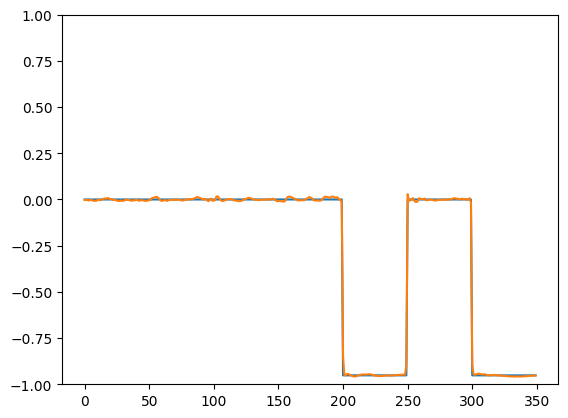

In [ ]:
#compare target and actual output
trial_num = 8
x = np.arange(0,350)
plt.plot(x,ytesttensor[trial_num,:,0])
plt.ylim(-1,1)
plt.plot(x,ytest_predict[trial_num,:,0])

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = frmodel.evaluate(xtesttensor, ytesttensor, batch_size=200)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 4s 742ms/step - loss: 2.2440e-04 - accuracy: 0.5333
test loss, test acc: [0.00022439853637479246, 0.5332542657852173]


In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(ytesttensor, ytest_predict).numpy()

0.00022383414

# Look At The Activities of The Recurrent Units

In [ ]:
# use input from distinct 9 categories
num_trials               = 1000
timesteps                = 350
num_orituned_input_units = 32
num_retrocue_input_units = 1
num_input_units          = num_orituned_input_units + num_retrocue_input_units
resp1_unit1 = np.zeros(num_trials)
resp1_unit2 = np.zeros(num_trials)
resp2_unit1 = np.zeros(num_trials)
resp2_unit2 = np.zeros(num_trials)


stims1_label     = np.arange(0,1000)
stims2_label     = np.arange(0,1000)
np.random.shuffle(stims1_label)
np.random.shuffle(stims2_label)
stims1     = stims1_label/1000*np.pi
stims2     = stims2_label/1000*np.pi
cues1      = np.random.choice(np.array([1,-1]),num_trials)
cues2      = np.random.choice(np.array([1,-1]),num_trials)

for tr in range(num_trials):
    if cues1[tr] == 1:
        resp1_unit1[tr] = np.cos(2*stims1[tr])
        resp1_unit2[tr] = np.sin(2*stims1[tr])
    else:
        resp1_unit1[tr] = np.cos(2*stims2[tr])
        resp1_unit2[tr] = np.sin(2*stims2[tr])

    if cues2[tr] == 1:
        resp2_unit1[tr] = np.cos(2*stims1[tr])
        resp2_unit2[tr] = np.sin(2*stims1[tr])
    else:
        resp2_unit1[tr] = np.cos(2*stims2[tr])
        resp2_unit2[tr] = np.sin(2*stims2[tr])

inputs  = np.zeros((num_trials, timesteps, num_input_units))
outputs = np.zeros((num_trials, timesteps, 2))

for tt in range(0, 50):
    resps1 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims1
             ]
    inputs[:, tt, :num_orituned_input_units] = resps1

for tt in range(100, 150):
    resps2 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims2
             ]
    inputs[:, tt, :num_orituned_input_units] = resps2

for tt in range(200, 250): #cue 1
    inputs[:,tt,-1] = cues1
    outputs[:,tt,0] = resp1_unit1
    outputs[:,tt,1] = resp1_unit2

for tt in range(300, 350): #cue 2
    inputs[:,tt,-1] = cues2
    outputs[:,tt,0] = resp2_unit1
    outputs[:,tt,1] = resp2_unit2


In [ ]:
#cues12 codes for the identity combinations of cues 1 and 2
cues12 = np.concatenate([[cues1], [cues2]]).T
cues12 = [tuple(el) for el in cues12]
# [kk for kk, jj in enumerate(cues12) if jj == (-1,-1)]

In [ ]:
inputs = tf.convert_to_tensor(inputs)
outputs = tf.convert_to_tensor(outputs)

print('inputs shape: ', inputs.shape)
print('outputs shape', outputs.shape)

inputs shape:  (1000, 350, 33)
outputs shape (1000, 350, 2)


In [ ]:
xtesttensor = inputs
ytesttensor = outputs

In [ ]:
frrnn_predictors = tf.keras.Model(frmodel.inputs, [frmodel.output, frmodel.layers[2].output])
preds = frrnn_predictors(xtesttensor)
recurrent_unit_activities = preds[1]

# Dynamics Visualization

In [ ]:
stims1_mat = stims1_label
stims2_mat = stims2_label
cues1_mat = cues1
cues2_mat = cues2

In [ ]:
########################### PCA separate from plotted data
print("Applying PCA GLOBALLY!")
effdims              = []
fanofactor           = []
evrs                 = []
global_pca_target_dim = 12
add_transformed_mean_back = False

ts_data = recurrent_unit_activities.numpy()
pca_ = PCA(n_components=global_pca_target_dim)

pc_proj              = np.zeros((ts_data.shape[0], ts_data.shape[1], global_pca_target_dim))
pc_comps             = np.zeros((global_pca_target_dim, ts_data.shape[2], ts_data.shape[1])) #12 x 100 x 350
pc_pev               = np.zeros((global_pca_target_dim, ts_data.shape[1])) # 12 x 350
for _tt in range(ts_data.shape[1]):
    pc_slice      = ts_data[:, _tt, :]
    pc_slice_proj = pca_.fit_transform(pc_slice)
    pc_proj[:,_tt,:] = pc_slice_proj
    cur_comps     = pca_.components_
    pc_comps[:,:,_tt] = cur_comps
    pc_pev[:,_tt] = pca_.explained_variance_ratio_ #Calculate percent variance explained
    evrs.append(pca_.explained_variance_ratio_)
    effdims.append(1./sum([ll**2 for ll in pca_.explained_variance_ratio_])) # Calculate effective dimensionality
    fanofactor.append(np.var(pc_slice)/np.mean(pc_slice))

global_pcaproj_ts_data = pc_proj
global_princomps       = pc_comps

Applying PCA GLOBALLY!


In [ ]:
#Plot effective dimensionality
plt.figure(figsize=(12,8))
plt.plot(effdims)
plt.axis([-5,355,0,7])
plt.xlabel('Time (steps)')
plt.ylabel('Effective dim. (a.u.)')
plt.grid()
plt.show()

In [ ]:
# Choose digits whose representations to plot and colors to plot them with
plot_digits = np.arange(0,1000)
plot_colors = sns.color_palette("Spectral", 1000).as_hex()

In [ ]:
color_dict = dict(zip(plot_digits, plot_colors))

colors = np.empty((global_pcaproj_ts_data.shape[0],
                   global_pcaproj_ts_data.shape[1],
                   2), dtype=object)
for _ts in range(global_pcaproj_ts_data.shape[1]):
    for trial_idx in range(global_pcaproj_ts_data.shape[0]):
        colors[trial_idx, _ts, 0] = color_dict[stims1_mat[trial_idx]]
        colors[trial_idx, _ts, 1] = color_dict[stims2_mat[trial_idx]]
print(color_dict)

In [ ]:
# Produce animations of dynamic visualizations
data   = np.transpose(global_pcaproj_ts_data, (1,0,2))
delay=.0

stframe = 0
stframe_disp_offset = 0
_label_fs = 22
_marker_size = 120

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,12),
                        gridspec_kw={'wspace':0.15, 'hspace':0.15},)
cm = plt.cm.get_cmap('RdYlBu')

# max_x = max([max([data[jj][kk][0] for kk in range(len(data[jj]))]) for jj in range(len(data))])
# min_x = min([min([data[jj][kk][0] for kk in range(len(data[jj]))]) for jj in range(len(data))])
# max_y = max([max([data[jj][kk][1] for kk in range(len(data[jj]))]) for jj in range(len(data))])
# min_y = min([min([data[jj][kk][1] for kk in range(len(data[jj]))]) for jj in range(len(data))])
# max_z = max([max([data[jj][kk][2] for kk in range(len(data[jj]))]) for jj in range(len(data))])
# min_z = min([min([data[jj][kk][2] for kk in range(len(data[jj]))]) for jj in range(len(data))])

nrows = len(data)

_cb_anchor = (-.3,0)
_cb_shrink = .95
_cb_tick_params_labelsize = 14
_cb_text_labelsize = 14

artist_objs = [None,] * 7

def init():
    for jj in range(6):
        if jj < 3:
            ax = axs[0, jj]
        else:
            ax = axs[1, jj-3]
        artist_objs[jj] = ax.scatter([], [], [])

    artist_objs[6] = fig.text(0.5, .95, '', fontsize=30,
                                horizontalalignment='center', verticalalignment='top',
                                transform=fig.transFigure,
                              )
    return artist_objs

def animate(jj):
    figcomment = f"Time step {stframe_disp_offset+jj+1}"

    for which_stim in [0,1]:
        for qq in [0,1,2]:
            XX, YY = data[jj, :, qq+0], data[jj, :, qq+1]

            xy_range = np.max([np.abs(XX),np.abs(YY)])

            max_range_width = 2.*xy_range
            min_x, max_x = np.mean(XX) - (1.1*max_range_width/2.), np.mean(XX) + (1.1*max_range_width/2.) # min(XX), max(XX)#
            min_y, max_y = np.mean(YY) - (1.1*max_range_width/2.), np.mean(YY) + (1.1*max_range_width/2.) # min(YY), max(YY)#

            ax = axs[which_stim, qq]
            ax.cla()
            for _cues in cue_markers:
                cues_idxs = [kk for kk, jj in enumerate(cues12) if jj == _cues]
                artist_objs[which_stim*3 + qq] = ax.scatter(XX[cues_idxs], YY[cues_idxs],
                                                            c=colors[cues_idxs, jj, which_stim],
                                                            marker=cue_markers[_cues],
                                                            cmap='hsv', s=_marker_size, alpha=0.75)
            ax.set_xlim([min_x, max_x]); ax.set_ylim([min_y, max_y])

            ax.set_xlabel(f"PC{qq+1}", fontsize=_label_fs, labelpad=2)
            ax.set_ylabel(f"PC{qq+2}", fontsize=_label_fs, labelpad=2)

    artist_objs[6].set_text(figcomment)

    bcp_OKBLUE(f'{jj+1 if jj%10 == 0 else ""}.')

    return artist_objs

cue_markers = {
    (1,1):  'o',
    (1,-1): '^',
    (-1,1): 's',
    (-1,-1):'P'
}
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=range(len(data)), interval=50, blit=False)
ani.save(f'./{model_path}_2D_equalRange_unMarked.mp4', fps=15, extra_args=['-vcodec', 'libx264'])


In [ ]:
#Plot PEV time courses
pc_pev = pc_pev * 100
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,351),pc_pev[0])
plt.plot(np.arange(1,351),pc_pev[1])
plt.plot(np.arange(1,351),pc_pev[2])
plt.plot(np.arange(1,351),pc_pev[3])
plt.axis([-5,355,0,100])
plt.xlabel('Timesteps')
plt.ylabel('Percent variance explained (%)')
plt.legend(['PC1','PC2','PC3','PC4'])

SIZE = 12
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

plt.grid()
plt.show()

# Export RNN recurrent unit activities for decoding

In [ ]:
#Counterbalancing trials (324)
stims1_label = np.zeros((9))
stims2_label = np.array((0,1,2,3,4,5,6,7,8))
for j in range(4):
  for i in range(9):
    if not (i == 0 and j == 0):
      a = np.zeros((9)) + i
      b = np.array((0,1,2,3,4,5,6,7,8))
      stims1_label = np.concatenate((stims1_label, a),axis = 0)
      stims2_label = np.concatenate((stims2_label, b),axis = 0)

cues1 = np.concatenate((np.ones((162))*1, np.ones((162))*(-1)))
cues2 = np.concatenate((np.ones((81))*1, np.ones((81))*(-1), np.ones((81))*1, np.ones((81))*(-1)))

In [ ]:
num_trials               = 324
timesteps                = 350
num_orituned_input_units = 32
num_retrocue_input_units = 1
num_input_units          = num_orituned_input_units + num_retrocue_input_units
resp1_unit1 = np.zeros(num_trials)
resp1_unit2 = np.zeros(num_trials)
resp2_unit1 = np.zeros(num_trials)
resp2_unit2 = np.zeros(num_trials)

index = np.arange(324)
np.random.shuffle(index)

stims1_label = stims1_label[index]
stims2_label = stims2_label[index]
cues1 = cues1[index]
cues2 = cues2[index]

stims1     = (stims1_label *20 +10+ np.random.uniform(-3,3))/180*np.pi #
stims2     = (stims2_label *20 +10+ np.random.uniform(-3,3))/180*np.pi #

for tr in range(num_trials):
  if cues1[tr] == 1:
    resp1_unit1[tr] = np.cos(2*stims1[tr])
    resp1_unit2[tr] = np.sin(2*stims1[tr])
  else:
    resp1_unit1[tr] = np.cos(2*stims2[tr])
    resp1_unit2[tr] = np.sin(2*stims2[tr])

  if cues2[tr] == 1:
    resp2_unit1[tr] = np.cos(2*stims1[tr])
    resp2_unit2[tr] = np.sin(2*stims1[tr])
  else:
    resp2_unit1[tr] = np.cos(2*stims2[tr])
    resp2_unit2[tr] = np.sin(2*stims2[tr])

inputs  = np.zeros((num_trials, timesteps, num_input_units))
outputs = np.zeros((num_trials, timesteps, 2))

for tt in range(0, 50):
    resps1 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims1
             ]
    inputs[:, tt, :num_orituned_input_units] = resps1

for tt in range(100, 150):
    resps2 = [get_orientation_tuned_firing_rate_response(stim, resolution = num_orituned_input_units,
                                                        sharpness = 4.0, max_spike = 50, noise_value = 0,)
              for stim in stims2
             ]
    inputs[:, tt, :num_orituned_input_units] = resps2

for tt in range(200, 250): #cue 1
    inputs[:,tt,-1] = cues1
    outputs[:,tt,0] = resp1_unit1
    outputs[:,tt,1] = resp1_unit2

for tt in range(300, 350): #cue 1
    inputs[:,tt,-1] = cues2
    outputs[:,tt,0] = resp2_unit1
    outputs[:,tt,1] = resp2_unit2

In [ ]:
stims1_label = stims1_label.astype(int)
stims2_label = stims2_label.astype(int)
cues1 = cues1.astype(int)
cues2 = cues2.astype(int)

In [ ]:
inputs = tf.convert_to_tensor(inputs)
outputs = tf.convert_to_tensor(outputs)
xtesttensor = inputs
ytesttensor = outputs
frrnn_predictors = tf.keras.Model(frmodel.inputs, [frmodel.output, frmodel.layers[2].output])
preds = frrnn_predictors(xtesttensor)
recurrent_unit_activities = preds[1]

In [ ]:
import scipy.io
hidden = recurrent_unit_activities.numpy()
scipy.io.savemat(f'/content/gdrive/My Drive/Noise001JitterPlus10_relu_20240113132728-Copy1_324_CB.mat', mdict={'stims1': stims1_label, 'stims2': stims2_label, 'cues1': cues1, 'cues2': cues2, 'hidden': hidden})